## Train GPT on point clouds

A simple modification of [minGPT](https://github.com/karpathy/minGPT) to work with point clouds.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

import mingpt.utils as utils

### Point Clouds (PC)
Point Clouds are set of points to represent 3D models. Each point has x,y,z values to specify the location of the point in a 3D coordinate system. In this dataset, there are 3746 chair models. All models have 1024 points in unit cube forming a (3746,1024,3) array. 

In [2]:
load_data = np.load("chair1024.npy")
train_size = int(len(load_data)*0.9)
train_PC = load_data[:train_size ,:, 0:3]
test_PC = load_data[train_size: ,:, 0:3]

print("Shape of the training set:", train_PC.shape)
print("Shape of the test set:", test_PC.shape)

points = train_PC.shape[1]
print(points , "points per point cloud model")

Shape of the training set: (3371, 1024, 3)
Shape of the test set: (375, 1024, 3)
1024 points per point cloud model


### k-means codebook strategy

All models are in unit cube (0.0-1.0) and we need to turn them into integers to feed into GPT model. For this purpose, I have used the same strategy as Image GPT by encoding every individual point into a codebook of 512 entries using k-means clustering algorithm. 

In [3]:
# get random 50 points per model and stack them all up

random_points = lambda x: x[np.random.choice(points,50,False )]
px = np.concatenate([random_points(x) for x in train_PC], axis=0)
print(px.shape)

(168550, 3)


In [4]:
# run kmeans to get our codebook

def kmeans(x, ncluster, niter=10):
    N, D = x.size()
    c = x[torch.randperm(N)[:ncluster]] # init clusters at random
    for i in range(niter):
        # assign all points to the closest codebook element
        a = ((x[:, None, :] - c[None, :, :])**2).sum(-1).argmin(1)
        # move each codebook element to be the mean of the points that assigned to it
        c = torch.stack([x[a==k].mean(0) for k in range(ncluster)])
        # re-assign any poorly positioned codebook elements
        nanix = torch.any(torch.isnan(c), dim=1)
        ndead = nanix.sum().item()
        print('done step %d/%d, re-initialized %d dead clusters' % (i+1, niter, ndead))
        c[nanix] = x[torch.randperm(N)[:ndead]] # re-init dead clusters
    return c

ncluster = 512
with torch.no_grad():
    C = kmeans(torch.from_numpy(px), ncluster, niter=8)

print(C.size())

done step 1/8, re-initialized 0 dead clusters
done step 2/8, re-initialized 0 dead clusters
done step 3/8, re-initialized 0 dead clusters
done step 4/8, re-initialized 0 dead clusters
done step 5/8, re-initialized 0 dead clusters
done step 6/8, re-initialized 0 dead clusters
done step 7/8, re-initialized 0 dead clusters
done step 8/8, re-initialized 0 dead clusters
torch.Size([512, 3])


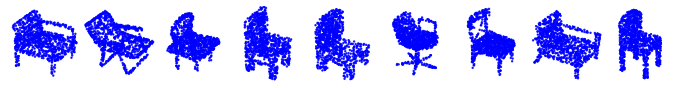

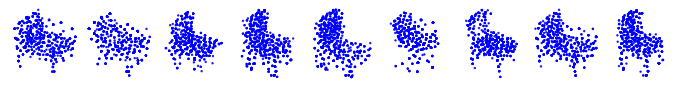

In [5]:
# encode the training examples with our codebook to visualize how much we've lost in the discretization

inputs = []
reconstructions = []

n_samples = 16

for i in range(n_samples):
    
    # encode and decode random point cloud models
    x = train_PC[np.random.randint(0, len(train_PC))]
    xpt = torch.from_numpy(x)
    ix = ((xpt[:, None, :] - C[None, :, :])**2).sum(-1).argmin(1) # cluster assignments for each point
    
    inputs.append(x)
    reconstructions.append(C[ix].numpy())
    
utils.plotPC(np.array(inputs))
utils.plotPC(np.array(reconstructions))

### TODO : Find a better discretization strategy.
Using more clusters provides better reconstruction as expected but causes poor GPT training. It may be prevented with more hyperparameter tuning.

Using more random points didn't do better.

In [6]:
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    """
    Dataset class to convert points into sequences of integers
    """
    
    def __init__(self, pt_dataset, clusters, perm=None):
        self.pt_dataset = pt_dataset
        self.clusters = clusters
        self.perm = torch.arange(points) if perm is None else perm
        
        self.vocab_size = clusters.size(0)
        self.block_size = points - 1
        
    def __len__(self):
        return len(self.pt_dataset)

    def __getitem__(self, idx):
        x = self.pt_dataset[idx]
        x = torch.from_numpy(np.array(x))
        x = x[self.perm].float() # reshuffle points with any fixed permutation and -> float
        a = ((x[:, None, :] - self.clusters[None, :, :])**2).sum(-1).argmin(1) # cluster assignments
        return a[:-1], a[1:] # always just predict the next one in the sequence

train_dataset = ImageDataset(train_PC, C)
test_dataset = ImageDataset(test_PC, C)


For reference, **iGPT-S** from the paper is:
- batch size of 128 and trained for 1M terations
- Adam lr 0.003 with betas = (0.9, 0.95)
- learning rate is warmed up for one epoch, then decays to 0
- did not use weight decay or dropout
- `n_layer=24, n_head=8, n_embd=512`

We will do something similar but smaller

In [7]:
from mingpt.model import GPT, GPTConfig, GPT1Config

# we'll do something a bit smaller
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  embd_pdrop=0.0, resid_pdrop=0.0, attn_pdrop=0.0,
                  n_layer=12, n_head=8, n_embd=256)
model = GPT(mconf)

The batch size is small because I am runing on a single RTX2070 GPU. If you have a GPU with more memory or more than one GPUs you can increase the batch size.

In [8]:
from mingpt.trainer import Trainer, TrainerConfig

tokens_per_epoch = len(train_PC) * train_dataset.block_size

train_epochs = 40

# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=train_epochs, batch_size=4, learning_rate=1e-3,
                      betas = (0.9, 0.95), weight_decay=0,
                      lr_decay=True, warmup_tokens=tokens_per_epoch, final_tokens=train_epochs*tokens_per_epoch,
                      ckpt_path='PC_model.pt',
                      num_workers=8)
trainer = Trainer(model, train_dataset, test_dataset, tconf)
trainer.train()

epoch 1 iter 842: train loss 5.78574. lr 1.000000e-03: 100%|██████████| 843/843 [03:19<00:00,  4.23it/s]
epoch 2 iter 842: train loss 5.69692. lr 9.983787e-04: 100%|██████████| 843/843 [03:21<00:00,  4.19it/s]
epoch 3 iter 842: train loss 5.67036. lr 9.935251e-04: 100%|██████████| 843/843 [03:21<00:00,  4.19it/s]
epoch 4 iter 842: train loss 5.64179. lr 9.854709e-04: 100%|██████████| 843/843 [03:21<00:00,  4.19it/s]
epoch 5 iter 842: train loss 5.62967. lr 9.742682e-04: 100%|██████████| 843/843 [03:21<00:00,  4.18it/s]
epoch 6 iter 842: train loss 5.60485. lr 9.599897e-04: 100%|██████████| 843/843 [03:15<00:00,  4.31it/s]
epoch 7 iter 842: train loss 5.59954. lr 9.427280e-04: 100%|██████████| 843/843 [03:21<00:00,  4.19it/s]
epoch 8 iter 842: train loss 5.57347. lr 9.225950e-04: 100%|██████████| 843/843 [03:19<00:00,  4.22it/s]
epoch 9 iter 842: train loss 5.55881. lr 8.997214e-04: 100%|██████████| 843/843 [03:21<00:00,  4.17it/s]
epoch 10 iter 842: train loss 5.55233. lr 8.742554e-04:

In [9]:
# load the state of the best model we've seen based on early stopping
checkpoint = torch.load('PC_model.pt')
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [10]:
# to sample we also have to technically "train" a separate model for the first token in the sequence
# we are going to do so below simply by calculating and normalizing the histogram of the first token
counts = torch.ones(ncluster) # start counts as 1 not zero, this is called "smoothing"
rp = torch.randperm(len(train_PC))
nest = 500 # how many images to use for the estimation
for i in range(nest):
    a, _ = train_dataset[int(rp[i])]
    t = a[0].item() # index of first token in the sequence
    counts[t] += 1
prob = counts/counts.sum()

In [11]:
%%time

from mingpt.utils import sample

n_samples = 16
start_point = np.random.choice(np.arange(C.size(0)), size=(n_samples, 1), replace=True, p=prob.numpy())
start_point = torch.from_numpy(start_point).to(trainer.device)
samples = sample(model, start_point, points-1, temperature=1.0, sample=True, top_k=100)

CPU times: user 1min 54s, sys: 496 ms, total: 1min 54s
Wall time: 1min 55s


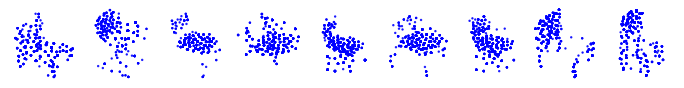

In [12]:
# for visualization we have to invert the permutation used to produce the pixels
iperm = torch.argsort(train_dataset.perm)

generations = []
for i in range(n_samples):
    pxi = samples[i][iperm] # note: undo the encoding permutation
    generations.append(C[pxi].numpy())
    
utils.plotPC(np.array(generations))

TODO : Train a bigger model with more epochs to generate better results (I am not sure if I can with a single GPU)